<a href="https://colab.research.google.com/github/ancastillar/Study-on-the-probability-of-payment-of-a-credit-requested-by-a-customer/blob/main/Model_LOAN_Logistic_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is structured as follows:

* Learn the basics of logistic regression models.
* Explore the existing data to get a rough idea of how each variable in the dataset interacts with the current loan status.
* Look at potential confounding effects.
* Fit a series of logistic regression models to determine whether or not verifying income source is significant.
* Perform a theoretical review of the most common metrics to measure the performance of classification algorithms



In [ ]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm
%matplotlib inline
from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from statsmodels.formula.api import ols
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib notebook
from IPython.display import display_html
plt.style.use('ggplot')
import matplotlib.colors as colors

# LOGISTIC REGRESSION

In linear regression we were concerned with learning the coefficients of a polynomial to predict the response of a continuous variable $y_i$ on unseen data based on its independent variables $x_i$. However, a wide variety of problems, such as classification, are concerned with outcomestaking the form of discrete variables (i.e.  categories)

In Logistic regression, each set of features $\mathbf{x}_i$ is associated with a category $C_i\in\{1,0\}$, with $i=1\ldots n$. It is helpful to re-define $\mathbf{x}$ to be an extended vector $\mathbf{x}\rightarrow (1,\mathbf{x})$. Then, the Likelihood function for Logistic regression is given by the sigmoid function

$$
P(c_i=1)=1-P(c_i=0)= {1 \over 1+ e^{-\mathbf{w}\cdot \mathbf{x}_i}},
$$

where $\mathbf{w}$ are the weights that define the logistic regression. Notice that this is just the Fermi function with $\beta E=-\mathbf{w}\cdot \mathbf{x}$.

 We will maximize the Log-likelihood of the observed data. Let us define the function
$$
f(a)={1 \over 1+ e^{-a}},
$$
Notice that the derivative with respect to $a$ is given by
$$
{df \over da}= f(1-f).
$$

Define $f_i \equiv f(\mathbf{w}\cdot \mathbf{x}_i)$. Then, the Likelihood of the data $\{ \mathbf{x}_i, C_i \}$ is given by
$$
P(Data|\mathbf{x})= \prod_{i=1}^n f_i^{C_i}(1-f_i)^{1-C_i}
$$
and the log-likelihood is given by
$$
\log{P(Data|\mathbf{w})}= \sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i)
$$

The negative of the log-likelihood gives us the cross-entropy error function
$$
\mathrm{Cross\,Entropy}=E(\mathbf{w})= -\sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i).
$$

Using the formula above notice that
$$
\nabla E(\mathbf{w})=\sum_{i=1}^n (f_i-C_i)\mathbf{x}_i.
$$
In other words, the gradient points in the sum of training example directions weighted by the difference between the true label and the probability of predicting that label.



##Finding the MLE Estimate ##

Notice the Maximum-Likelihood Estimation (MLE) is the same as minimizing the cross-entropy. There is no closed form expression for this. One strategy is to start with an arbitrary $\mathbf{w}$ and then update our estimate based on our error function. In particular, we would like to nudge $\mathbf{w}$ in the direction where the error is decreasing the fastest. This is the idea behind gradient descent. Furthermore, we can show that the cross-entropy error function used in logistic regression has a unique minimum. Thus, we can perform this procedure with relative ease (However, as a word of caution, note there is a generic instability in the MLE procedure for linearly separable data).

Theoretically, one nice method for doing this is the <i> Newton-Raphson </i> method. In this method, we iteratively calculate the gradient 
$$
\mathbf{w}^{new} \leftarrow \mathbf{w}^{old} - \mathbf{H}^{-1} \nabla E(\mathbf{w}),
$$
where $\mathbf{H}$ is the Hessian matrix which is the second derivative of the energy function.[1]



Dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data_davivienda/Lending_club.csv')
#Transformation of variables

#Change loan_status, verification_status, emp_length, term and grade to category type 
df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=['Charged Off', 'Fully Paid']))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=['< 1 year', '1 year', '2 years', '3 years', '4 years', \
                                                             '5 years', '6 years', '7 years', '8 years', '9 years', \
                                                             '10+ years']))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=['RENT','MORTGAGE','OWN','OTHER']))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[' 36 months', ' 60 months']))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=['A','B','C','D','E','F','G']))
df.purpose = df.purpose.astype(pd.api.types.CategoricalDtype(categories=['debt_consolidation','credit_card','other','home_improvement','major_purchase','small_business','car', 'wedding','medical','moving','house','vacation','educational','renewable_energy']))

#In addition, the original data in int_rate contains strings of the form 'x.xx%',
#we remove the % and change the vaules to float:
df.int_rate = df.int_rate.str.rstrip('%').astype('float')

In [ ]:
df_log1 = pd.DataFrame(columns=['verification_status','loan_status'])
df_log1['verification_status'] = df.verification_status.cat.codes
df_log1['loan_status'] = df.loan_status.cat.codes
df_log1['Intercept'] = 1

logit = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','verification_status']])
logit_res = logit.fit()
logit_res.summary()



Optimization terminated successfully.
         Current function value: 0.405007
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38703
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Nov 2020   Pseudo R-squ.:                0.002350
Time:                        05:48:40   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 8.419e-18
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9469      0.022     88.290      0.000       1.904       1.990
verification_status    -0.1460      0.017     -8.600      0.000      -0.179      -0.113
=======================================================================================
"""

Now we are going to study the relationship between the variables: 

---

<code>loan_status</code>,<code>loan_amount</code> and <code>int_rate</code>. We are proceeding similar to before:

In [ ]:
df6=df.copy()
df6['loan_status'] = df6.loan_status.cat.codes
df6['loan_amnt']=(df6['loan_amnt']-df6['loan_amnt'].mean())/df6['loan_amnt'].std()
df6['int_rate']=(df6['int_rate']-df6['int_rate'].mean())/df6['int_rate'].std()
df6['Intercept'] = 1

logit2 = sm.Logit(df6['loan_status'], df6[['Intercept','loan_amnt','int_rate']])
logit_res2 = logit2.fit()
logit_res2.summary()

Optimization terminated successfully.
         Current function value: 0.386118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38702
Method:                           MLE   Df Model:                            2
Date:                Thu, 26 Nov 2020   Pseudo R-squ.:                 0.04888
Time:                        05:48:46   Log-Likelihood:                -14945.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9277      0.016    119.842      0.000       1.896       1.959
loan_amnt      0.0399      0.015      2.664      0.008       0.011       0.069
int_rate      -0.5862      0.016    -36.901      0.000      -0.617      -0.555
==============================================================================
"""

<h3>The Receiver Operating Characteristic (ROC) curve</h3>
<p>We have seen the great potential in considering the TPR and TNR to help select the appropriate threshold for our models. However, it does not makes much sense to compute these for single cut-off values. We ought to summarize the prediction accuracy across all different cut-off values to produce a unified evalution of our model. This is the motivation for the <strong>receiver operating characteristic (ROC) curve</strong>.</p>
<p>The ROC curve plots 1 - TNR against TPR and illustrates the behavior of a logistic model as the cut-off point changes.</p>

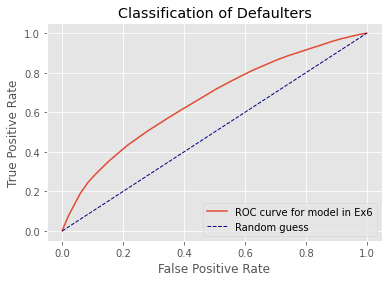

In [ ]:
%matplotlib inline


#Results of logistic regression
b_Intercept=1.9277 
b_loan_amnt=0.0399 
b_int_rate=-0.5862


def rates(p):
    a= df6.loan_status
    b=(b_Intercept+b_loan_amnt*df6['loan_amnt']+b_int_rate*df6['int_rate']>np.log(p/(1-p))).astype('int')
    
    TPR=(a & b).sum(axis=0)/a.sum(axis=0)
    TNR=(1-a & 1-b).sum(axis=0)/(1-a).sum(axis=0)
    return [TPR,TNR]

#Luego, usamos esta función para trazar la curva ROC
x=[]
y=[]
for p in np.arange(0.01,0.99,0.01):
    z=rates(p)
    y.append(z[0])
    x.append(1-z[1])
    
fig, ax = plt.subplots()

ax.plot(x,y, label=f'ROC curve for model in Ex6')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right');

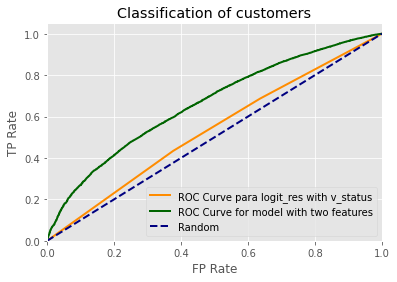

In [ ]:
%matplotlib inline
predict_p = logit_res.predict(df_log1[['Intercept','verification_status']])
predict_2_p = logit_res2.predict(df6[['Intercept','loan_amnt','int_rate']])
roc_p = roc_curve(df_log1['loan_status'], predict_p)
roc_2_p = roc_curve(df6['loan_status'], predict_2_p)

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=line_width, label=f'ROC Curve para logit_res with v_status')
plt.plot(roc_2_p[0], roc_2_p[1], color='darkgreen',
         lw=line_width, label=f'ROC Curve for model with two features')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('Classification of customers')
plt.legend(loc='lower right')
plt.show()

<h3>Comparing models using the area under the curve (AUC)</h3>

<p>One way to summarize the whole ROC curve is by computing the <strong>area under the curve (AUC)</strong>. Roughly speaking, AUC indicates the probability that a randomly selected defaulter will have smaller <strong>$p$</strong> than a randomly selected non-defaulter.</p>
<p>If AUC is close to one, then the rule is close to a perfect rule. The ROC curve for a random guess rule (set $p = 0.5$ for all applicants) is the diagonal line in the plot and usually serves as a baseline to check if the classification model learns any information from the data above and beyond pure randomness. We can compute the AUC after calculation of the ROC curve using the function <code>auc</code> from <code>sklearn.metrics</code>:</p>

In [ ]:
auc_p = auc( roc_p[0], roc_p[1] )
auc_2_p = auc( roc_2_p[0], roc_2_p[1] )

print('AUC of first logistic regression: ', auc_p)
print('AUC of model with two features: ', auc_2_p)



AUC of first logistic regression:  0.5340366188185781
AUC of model with two features:  0.6615528294400581


The best performance between the two models is the model with two features, because the area under the auc curve is greater

**Now we are going to carry out the appropriate pre-processing to vectorize the category variables and study in detail their correlation.**

In [ ]:
df_pre = pd.concat([(df.loan_amnt - df.loan_amnt.mean())/df.loan_amnt.std(),\
                     (df.int_rate - df.int_rate.mean())/df.int_rate.std(),\
                     (df.annual_inc - df.annual_inc.mean())/df.annual_inc.std(),\
                     pd.get_dummies(df.home_ownership, prefix='home', drop_first=True), \
                     pd.get_dummies(df.purpose, prefix='purpose', drop_first=True), \
                     pd.get_dummies(df.grade, prefix='grade',drop_first=True)], axis=1)
df_pre['verification_status'] = df.verification_status.cat.codes
df_pre['emp_length'] = df.emp_length.cat.codes
df_pre['term'] = df.term.cat.codes
df_pre['Intercept'] = 1

In [ ]:
df_pre.head()

,loan_amnt,int_rate,annual_inc,home_MORTGAGE,home_OWN,home_OTHER,purpose_credit_card,purpose_other,purpose_home_improvement,purpose_major_purchase,purpose_small_business,purpose_car,purpose_wedding,purpose_medical,purpose_moving,purpose_house,purpose_vacation,purpose_educational,purpose_renewable_energy,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,verification_status,emp_length,term,Intercept
0,-0.843862,-0.378954,-0.710290,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,10,0,1
1,-1.178519,0.863143,-0.616866,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1
2,-1.191906,1.048651,-0.893213,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,10,0,1
3,-0.174546,0.384586,-0.317912,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,10,0,1
4,-1.111588,0.169505,0.161661,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1


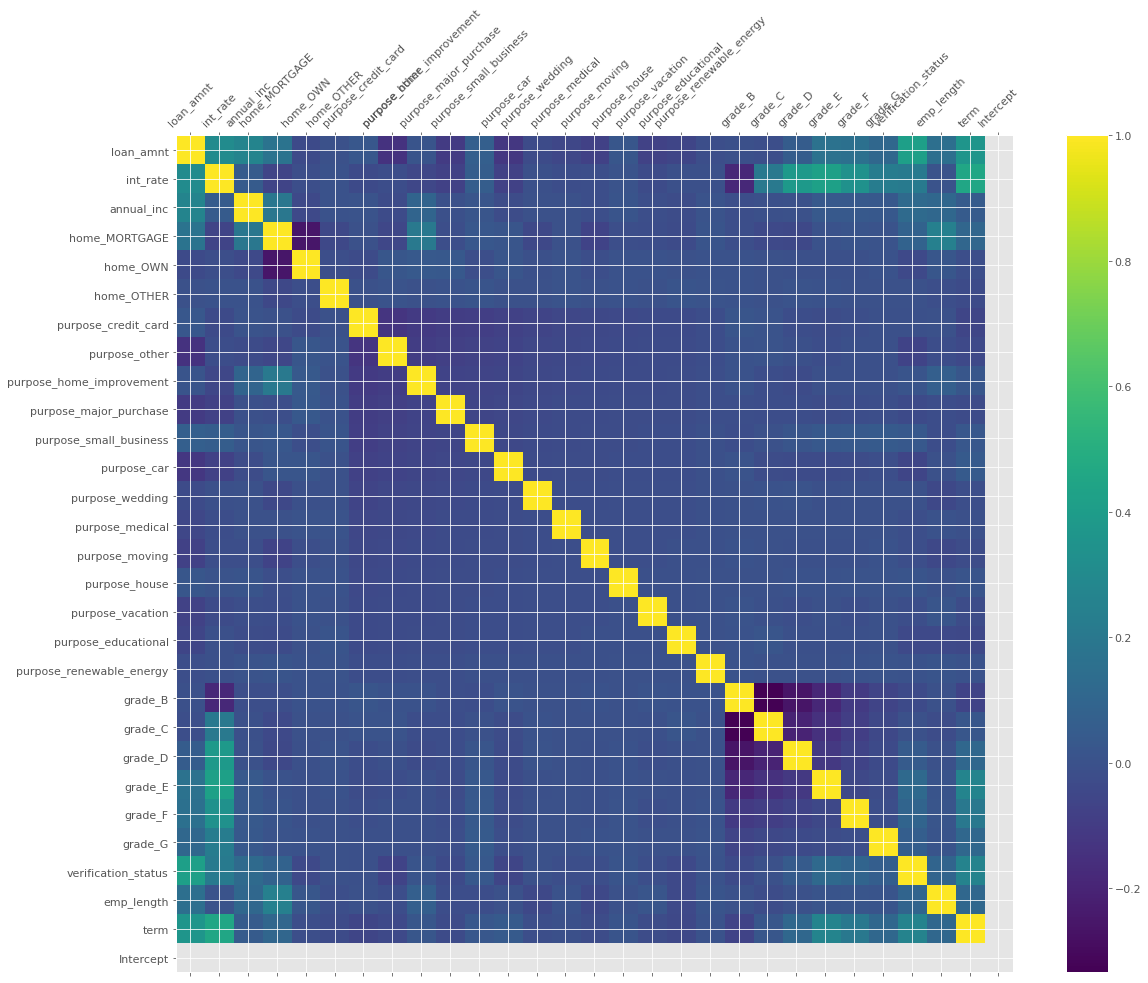

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_pre.corr(), fignum=f.number)
plt.xticks(range(df_pre.shape[1]), df_pre.columns, fontsize=11, rotation=45)
plt.yticks(range(df_pre.shape[1]), df_pre.columns, fontsize=11)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=11)
#plt.title('Correlation Matrix', fontsize=16);

In [ ]:
logit_full1 = sm.Logit(df.loan_status.cat.codes, df_pre) # The importance of the variables regarding loan_status
logit_full1_res = logit_full1.fit()
logit_full1_res.summary()

Optimization terminated successfully.
         Current function value: 0.378075
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38676
Method:                           MLE   Df Model:                           28
Date:                Thu, 26 Nov 2020   Pseudo R-squ.:                 0.06869
Time:                        01:42:13   Log-Likelihood:                -14633.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
loan_amnt                   -0.0075      0.019     -0.389      0.697      -0.045       0.030
int_rate                    -0.4050      0.054     -7.454      0.000      -0.511      -0.299
annual_inc                   0.3615      0.031     11.641      0.000       0.301       0.422
home_MORTGAGE                0.0382      0.035      1.095      0.273      -0.030       0.107
home_OWN                     0.0209      0.060      0.348      0.728      -0.097       0.138
home_OTHER                  -0.4454      0.268     -1.660      0.097      -0.971       0.080
purpose_credit_card          0.2554      0.052      4.897      0.000       0.153       0.358
purpose_other               -0.1860      0.052     -3.609      0.000      -0.287      -0.085
purpose_home_improvement     0.0566      0.065      0.867      0.386      -0.071       0.185
purpose_major_purchase       0.2166      0.078      2.779      0.005       0.064       0.369
purpose_small_business      -0.7224      0.060    -11.981      0.000      -0.841      -0.604
purpose_car                  0.2190      0.091      2.405      0.016       0.041       0.398
purpose_wedding              0.3538      0.114      3.098      0.002       0.130       0.578
purpose_medical             -0.1755      0.114     -1.545      0.122      -0.398       0.047
purpose_moving              -0.1956      0.124     -1.573      0.116      -0.439       0.048
purpose_house               -0.1365      0.148     -0.921      0.357      -0.427       0.154
purpose_vacation            -0.2181      0.159     -1.373      0.170      -0.529       0.093
purpose_educational         -0.3473      0.156     -2.220      0.026      -0.654      -0.041
purpose_renewable_energy    -0.5052      0.274     -1.846      0.065      -1.042       0.031
grade_B                     -0.2733      0.074     -3.709      0.000      -0.418      -0.129
grade_C                     -0.3549      0.103     -3.448      0.001      -0.557      -0.153
grade_D                     -0.3775      0.132     -2.860      0.004      -0.636      -0.119
grade_E                     -0.2973      0.160     -1.859      0.063      -0.611       0.016
grade_F                     -0.3238      0.194     -1.669      0.095      -0.704       0.057
grade_G                     -0.1802      0.238     -0.757      0.449      -0.647       0.286
verification_status          0.0082      0.020      0.411      0.681      -0.031       0.047
emp_length                  -0.0147      0.004     -3.301      0.001      -0.023      -0.006
term                        -0.4520      0.037    -12.081      0.000      -0.525      -0.379
Intercept                    2.3972      0.088     27.117      0.000       2.224       2.571
============================================================================================
"""

We can observe que la variable <code> verification_status</code> is not relevant for the model when include all the variables.

**Prediction**

In [ ]:
predict_withvs = logit_full1_res.predict(df_pre)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


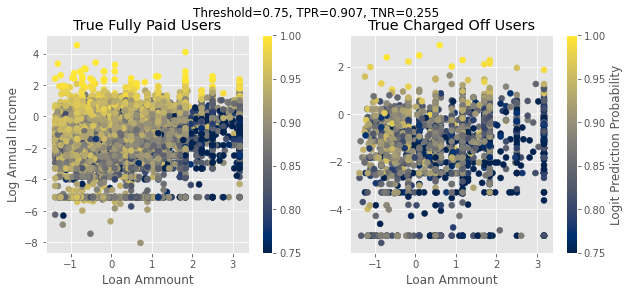

In [ ]:
%matplotlib inline
#The following plot compares the Logit classification of Fully Paid vs. Charged Off users. 
#Brighter points indicate users that would be given higher chances to get the loan based in this model with the select threshold.
#%matplotlib notebook

df_log_plot=df_pre.copy()
df_log_plot['loan_status']=df['loan_status']
df_log_plot['logit_predict']=predict_withvs


fig,ax=plt.subplots(1,2,figsize=(10,4))
dff2=df_log_plot[df_log_plot['loan_status']=='Fully Paid']
plot2=ax[0].scatter(dff2['loan_amnt'],np.log(dff2['annual_inc']),c=dff2['logit_predict'],cmap='cividis')
cbar2 = plt.colorbar(plot2,ax=ax[0])
ax[0].set_ylabel('Log Annual Income')
ax[0].set_xlabel('Loan Ammount')
ax[0].set_title('True Fully Paid Users')

dff1=df_log_plot[df_log_plot['loan_status']=='Charged Off']
plot1=ax[1].scatter(dff1['loan_amnt'],np.log(dff1['annual_inc']),c=dff1['logit_predict'],cmap='cividis')
cbar1 = plt.colorbar(plot1,ax=ax[1])
cbar1.set_label('Logit Prediction Probability')
ax[1].set_xlabel('Loan Ammount')
ax[1].set_title('True Charged Off Users')


def update(threshold):
    plot1.set_norm(norm=colors.Normalize(vmin=threshold,vmax=1.))

    
    plot2.set_norm(norm=colors.Normalize(vmin=threshold,vmax=1.))
  
    
    TPR=df_log_plot[(df_log_plot['loan_status']=='Fully Paid') & (df_log_plot['logit_predict']>=threshold)]['loan_status'].count()/df_log_plot[df_log_plot['loan_status']=='Fully Paid']['loan_status'].count()
    TNR=df_log_plot[(df_log_plot['loan_status']=='Charged Off') & (df_log_plot['logit_predict']<=threshold)]['loan_status'].count()/df_log_plot[df_log_plot['loan_status']=='Charged Off']['loan_status'].count()
    
    fig.suptitle('Threshold={:.2f}, TPR={:.3f}, TNR={:.3f}'.format(threshold,TPR,TNR))
    fig.canvas.draw_idle();

  
#interact(update, threshold=(0,1,0.01));

update(0.75);  

**Why the Simsonp paradox is present in the variable <code>verification_status</code>?**

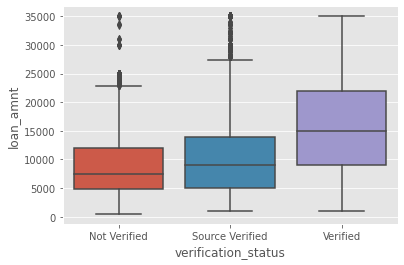

In [ ]:
sns.boxplot(y='loan_amnt', x='verification_status', data = df)

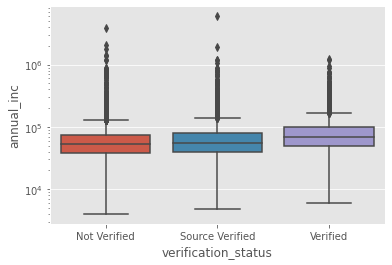

In [ ]:
sns.boxplot(y='annual_inc', x='verification_status', data = df).set_yscale('log')

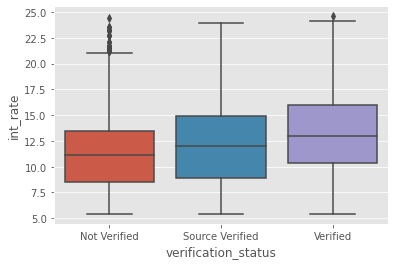

In [ ]:
sns.boxplot(y='int_rate', x='verification_status', data = df)

**From the above charts we can see that small loans are generally applied for by people whose employment is not verified. In addition, we can see that the lowest loan interest rate is for people who do not verify their employment. This may be the cause of the Simpson paradox.**

##Other test for importance of the variable <code>verification_status</code>##

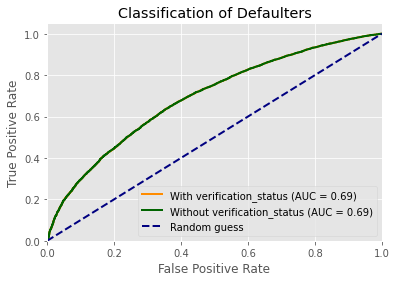

In [ ]:
df_log2=df_pre
predict_withvs = logit_full1_res.predict(df_log2)
logit_full_novs = sm.Logit(df.loan_status.cat.codes, df_log2.loc[:, df_log2.columns != 'verification_status'])
predict_novs = logit_full_novs.fit(disp=0).predict(df_log2.loc[:, df_log2.columns != 'verification_status'])

roc_vs = roc_curve(df.loan_status.cat.codes, predict_withvs)
roc_novs = roc_curve(df.loan_status.cat.codes, predict_novs)
auc_vs = auc( roc_vs[0], roc_vs[1] )
auc_novs = auc( roc_novs[0], roc_novs[1])

plt.figure()
line_width = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange',
         lw=line_width, label=f'With verification_status (AUC = {auc_vs:0.2f})')
plt.plot(roc_novs[0], roc_novs[1], color='darkgreen',
         lw=line_width, label=f'Without verification_status (AUC = {auc_novs:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()

**We find that the AUC for the model with <code>verification_status</code> included is the same as the model without <code>verification_status</code> included (0.69). Since we always want our model to be as simple as possible, this means that we should not include <code>verification_status</code> as a variable when predicting whether a user is likely to pay his or her debt.**

##Cross-validation to diagnose variance problems or bias problems##

In [ ]:
# generate cross-validated ROC and AUC for logistic regression model

def cv_roc(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        logit = sm.Logit(y.iloc[train], X.iloc[train])
        logit_res = logit.fit(disp=0)
        probas_ = logit_res.predict(X.iloc[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

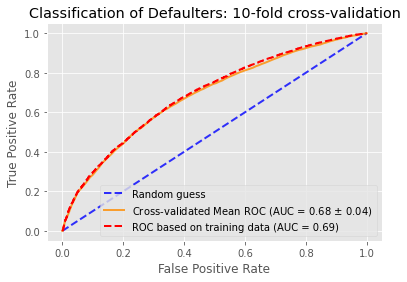

In [ ]:
# plot the cross-validated ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc(df_pre, df['loan_status'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Defaulters: 10-fold cross-validation')
plt.show()

 The difference between the two curves is small, indicating the overfitting problem is not material in our case.

 Remenber that: 

 We have variance problems when CV error of $\hat{f}$ > training set error of $\hat{f}$. Therefore we have overfittting problem, we can solve this with: 

*   Decrease the model complexity

By the other hand we have bias problem when CV error $\hat{f} \approx $ training set error and $\hat{f}\gg$ desired error. Therefor we said that $\hat{f}$ underfit the training set. To remedy underfitting:


*   Increase the model complexity
*   gather more relevant features






#Conclusions
In this case, we investigated whether the verification status of applicants' income source is important when predicting if an applicant will pay off his/her debt. We constructed a logistic model to first examine the marginal relationship between verification status and probability of pay-off. We discovered a counterintuitive trend: less reliable income source information was correlated with higher pay-off probability. However, after fitting a larger logistic model with all independent variables that were available, we found that this trend was introduced via confounding effects of interest rate, annual income, and loan term.

After accounting for these variables, verification status was no longer significantly associated with pay-off probability. Based on $p$-values and the model ROC, we concluded that the verification process is irrelevant and we could potentially remove it from the required items and simplify the lending process.  
Logistic regression naturally extends the concept of linear regression and is the benchmark model for performing classification tasks. The coefficients have similar interpretation as those of linear regression. ROC curves are then useful for comparing different classification models.

Logistic regression is only one of many different tools used in classification. While simple, it performs fairly well and needs relatively little data to train compared to other, more modern classifiers. While we only studied the binary case, there are extensions of logistic regression to handle multi-class and ordinal regression as well (you can read up on these in your own time).

#Evaluation of classification models (Theory)

##Precision and Recall##



**Precision:**
The accuracy of the positive predictions; this is called the precision of the classifier and we can define it as follow:

> precision=$\frac{TP}{TP+FP}$

Where TP is the number of true positives, and FP is the number of false positives. A trivial way to have perfect precision is to make one single  positive  prediction  and ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since the classifier would ignore all but one positive instance.

**Recall**
So precision is typically used along with another metric named recall, also called sensitivity or the true positive rate(TPR): this is the ratio of positive instances that are correctly detected by the classifier


> recall=$\frac{TP}{TP+FN}$

Other important concept is the Confusion Matrix. The general idea is to count the number of times instances of class A areclassified as class B. we can visualize this concept in the following figure:

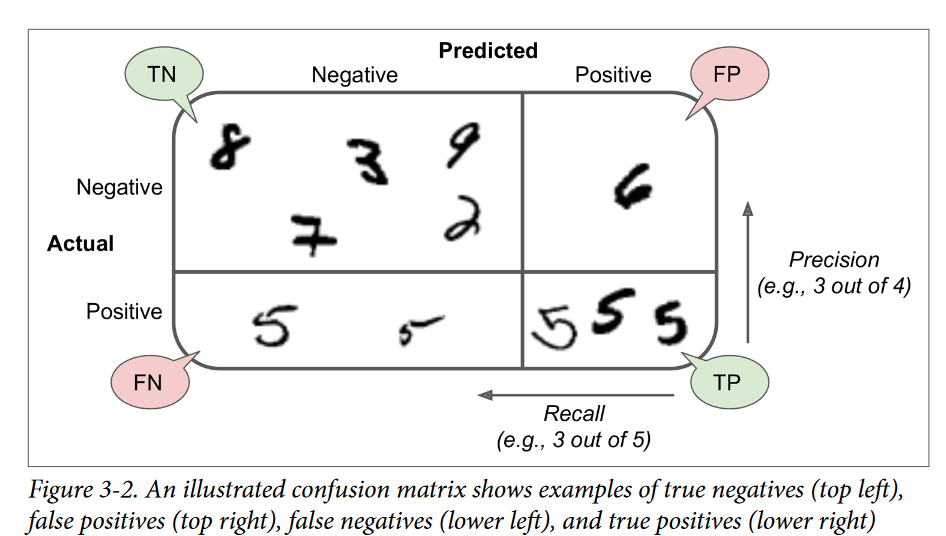



It is often convenient to combine precision and recall into a single metric called the F1 score, **in particular if you need a simple way to compare two classifiers**. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats  all  values  equally, the  harmonic  mean  gives  much  more  weight  to  low  values. As a result, the classifier will only get a high F1 score if both recall and precision are high. [2]


> F1= $2 \times \frac{precicion\times recall }{precision+ recall}= \frac{TP}{TP+ \frac{FN + FP}{2} }$




#REFERENCES:

[1] Pankaj Mehta, Ching-Hao Wang, Alexandre G. R. Day, and Clint Richardson,  *A high-bias, low-variance introduction to Machine Learning for physicists*. 27 May 2019.  https://arxiv.org/pdf/1803.08823.pdf

[2] Aurélien Géron, Hands-on  Machine Learning   with  Scikit-Learn, Keras & TensorFlow. SECOND EDITION. September 2019.